In [1]:
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torch
from config.kitti_3d_multi_warmup import *
from torchvision import models
from Dataset import *
import pickle
from py_cpu_nms import *
import glob
from nms_new import new_nms

In [2]:
conf= Config()

In [3]:
DATASET = r'E:\Thesis_Final\A2D2_dataset'
IMG_DIR = DATASET + "/images/"
LABEL_DIR = DATASET + "/A2D2_3D_Obj_det_label_txt/"
CSV_Path= DATASET+ "/subset2.csv"

In [4]:
dataset = A2D2_3D_det_Dataset(image_dir= IMG_DIR, label_dir= LABEL_DIR, csv_file= CSV_Path,transform= None)
print(np.shape(dataset[0].image))

(3, 304, 480)


In [5]:
test_data= torch.utils.data.DataLoader(dataset, batch_size= 1 , shuffle = False, num_workers = 0)
print(len(dataset))

98


In [6]:
def pickle_write(file_path, obj):
    """
    Serialize an object to a provided file_path
    """

    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)


def pickle_read(file_path):
    """
    De-serialize an object from a provided file_path
    """

    with open(file_path, 'rb') as file:
        return pickle.load(file)

In [7]:
precomputed = True
cache_folder = r"E:\Thesis_Final\Baseline\M3D-RPN"

In [8]:
if precomputed == True:
    conf.anchors = pickle_read(os.path.join(cache_folder, 'anchors.pkl'))
    conf.bbox_means = pickle_read(os.path.join(cache_folder, 'bbox_means.pkl'))
    conf.bbox_stds = pickle_read(os.path.join(cache_folder, 'bbox_stds.pkl'))

## Load Trained Model

In [9]:
def dilate_layer(layer, val):
    layer.dilation = val
    layer.padding = val


class LocalConv2d(nn.Module):

    def __init__(self, num_rows, num_feats_in, num_feats_out, kernel=1, padding=0):
        super(LocalConv2d, self).__init__()

        self.num_rows = num_rows
        self.out_channels = num_feats_out
        self.kernel = kernel
        self.pad = padding

        self.group_conv = nn.Conv2d(num_feats_in * num_rows, num_feats_out * num_rows, kernel, stride=1, groups=num_rows)

    def forward(self, x):

        b, c, h, w = x.size()

        if self.pad: x = F.pad(x, (self.pad, self.pad, self.pad, self.pad), mode='constant', value=0)

        t = int(h / self.num_rows)

        # unfold by rows
        x = x.unfold(2, t + self.pad*2, t)
        x = x.permute([0, 2, 1, 4, 3]).contiguous()
        x = x.view(b, c * self.num_rows, t + self.pad*2, (w+self.pad*2)).contiguous()

        # group convolution for efficient parallel processing
        y = self.group_conv(x)
        y = y.view(b, self.num_rows, self.out_channels, t, w).contiguous()
        y = y.permute([0, 2, 1, 3, 4]).contiguous()
        y = y.view(b, self.out_channels, h, w)

        return y
def flatten_tensor(input):
    """
    Flattens and permutes a tensor from size
    [B x C x W x H] --> [B x (W x H) x C]
    """

    bsize = input.shape[0]
    csize = input.shape[1]

    return input.permute(0, 2, 3, 1).contiguous().view(bsize, -1, csize)


def unflatten_tensor(input, feat_size, anchors):
    """
    Un-flattens and un-permutes a tensor from size
    [B x (W x H) x C] --> [B x C x W x H]
    """

    bsize = input.shape[0]

    if len(input.shape) >= 3: csize = input.shape[2]
    else: csize = 1

    input = input.view(bsize, feat_size[0] * anchors.shape[0], feat_size[1], csize)
    input = input.permute(0, 3, 1, 2).contiguous()

    return input


[11]
class RPN(nn.Module):

    def __init__(self, phase, base,conf):
        super(RPN, self).__init__()

        self.base = base

        del self.base.transition3.pool

        # dilate
        dilate_layer(self.base.denseblock4.denselayer1.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer2.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer3.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer4.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer5.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer6.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer7.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer8.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer9.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer10.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer11.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer12.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer13.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer14.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer15.conv2, 2)
        dilate_layer(self.base.denseblock4.denselayer16.conv2, 2)

        # settings
        self.phase = phase
        self.num_classes = len(conf['lbls']) + 1
        #self.num_classes = len(conf['lbls'])
        self.num_anchors = conf['anchors'].shape[0]

        self.num_rows = int(min(conf.bins, calc_output_size(conf.test_scale, conf.feat_stride)))
        print(self.num_rows)
        self.prop_feats = nn.Sequential(
            nn.Conv2d(self.base[-1].num_features, 512, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        # outputs
        self.cls = nn.Conv2d(self.prop_feats[0].out_channels, self.num_classes * self.num_anchors, 1, )

        # bbox 2d
        self.bbox_x = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_y = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_w = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_h = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)

        # bbox 3d
        self.bbox_x3d = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_y3d = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_z3d = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_w3d = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_h3d = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_l3d = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_rY3d = nn.Conv2d(self.prop_feats[0].out_channels, self.num_anchors, 1)

        self.prop_feats_loc = nn.Sequential(
            LocalConv2d(self.num_rows, self.base[-1].num_features, 512, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # outputs
        self.cls_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_classes * self.num_anchors, 1, )

        # bbox 2d
        self.bbox_x_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_y_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_w_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_h_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)

        # bbox 3d
        self.bbox_x3d_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_y3d_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_z3d_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_w3d_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_h3d_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_l3d_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)
        self.bbox_rY3d_loc = LocalConv2d(self.num_rows, self.prop_feats[0].out_channels, self.num_anchors, 1)
       
        self.cls_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))

        self.bbox_x_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))
        self.bbox_y_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))
        self.bbox_w_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))
        self.bbox_h_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))

        self.bbox_x3d_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))
        self.bbox_y3d_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))
        self.bbox_z3d_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))
        self.bbox_w3d_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))
        self.bbox_h3d_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))
        self.bbox_l3d_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))
        self.bbox_rY3d_ble = nn.Parameter(torch.tensor(10e-5).type(torch.FloatTensor))

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        self.feat_stride = conf.feat_stride
        self.feat_size = calc_output_size(np.array(conf.crop_size), self.feat_stride)
        self.rois = locate_anchors(conf.anchors, self.feat_size, conf.feat_stride, convert_tensor=True)
        self.rois = self.rois.type(torch.cuda.FloatTensor)
        
        self.anchors = conf.anchors
        self.bbox_means = conf.bbox_means
        self.bbox_stds = conf.bbox_stds
        
    def forward(self, x):

        batch_size = x.size(0)

        # resnet
        x = self.base(x)

        prop_feats = self.prop_feats(x)
        prop_feats_loc = self.prop_feats_loc(x)

        cls = self.cls(prop_feats)

        # bbox 2d
        bbox_x = self.bbox_x(prop_feats)
        bbox_y = self.bbox_y(prop_feats)
        bbox_w = self.bbox_w(prop_feats)
        bbox_h = self.bbox_h(prop_feats)

        # bbox 3d
        bbox_x3d = self.bbox_x3d(prop_feats)
        bbox_y3d = self.bbox_y3d(prop_feats)
        bbox_z3d = self.bbox_z3d(prop_feats)
        bbox_w3d = self.bbox_w3d(prop_feats)
        bbox_h3d = self.bbox_h3d(prop_feats)
        bbox_l3d = self.bbox_l3d(prop_feats)
        bbox_rY3d = self.bbox_rY3d(prop_feats)

        cls_loc = self.cls_loc(prop_feats_loc)

        # bbox 2d
        bbox_x_loc = self.bbox_x_loc(prop_feats_loc)
        bbox_y_loc = self.bbox_y_loc(prop_feats_loc)
        bbox_w_loc = self.bbox_w_loc(prop_feats_loc)
        bbox_h_loc = self.bbox_h_loc(prop_feats_loc)

        # bbox 3d
        bbox_x3d_loc = self.bbox_x3d_loc(prop_feats_loc)
        bbox_y3d_loc = self.bbox_y3d_loc(prop_feats_loc)
        bbox_z3d_loc = self.bbox_z3d_loc(prop_feats_loc)
        bbox_w3d_loc = self.bbox_w3d_loc(prop_feats_loc)
        bbox_h3d_loc = self.bbox_h3d_loc(prop_feats_loc)
        bbox_l3d_loc = self.bbox_l3d_loc(prop_feats_loc)
        bbox_rY3d_loc = self.bbox_rY3d_loc(prop_feats_loc)

        cls_ble = self.sigmoid(self.cls_ble)

        # bbox 2d
        bbox_x_ble = self.sigmoid(self.bbox_x_ble)
        bbox_y_ble = self.sigmoid(self.bbox_y_ble)
        bbox_w_ble = self.sigmoid(self.bbox_w_ble)
        bbox_h_ble = self.sigmoid(self.bbox_h_ble)

        # bbox 3d
        bbox_x3d_ble = self.sigmoid(self.bbox_x3d_ble)
        bbox_y3d_ble = self.sigmoid(self.bbox_y3d_ble)
        bbox_z3d_ble = self.sigmoid(self.bbox_z3d_ble)
        bbox_w3d_ble = self.sigmoid(self.bbox_w3d_ble)
        bbox_h3d_ble = self.sigmoid(self.bbox_h3d_ble)
        bbox_l3d_ble = self.sigmoid(self.bbox_l3d_ble)
        bbox_rY3d_ble = self.sigmoid(self.bbox_rY3d_ble)

        # blend
        cls = (cls * cls_ble) + (cls_loc * (1 - cls_ble))

        bbox_x = (bbox_x * bbox_x_ble) + (bbox_x_loc * (1 - bbox_x_ble))
        bbox_y = (bbox_y * bbox_y_ble) + (bbox_y_loc * (1 - bbox_y_ble))
        bbox_w = (bbox_w * bbox_w_ble) + (bbox_w_loc * (1 - bbox_w_ble))
        bbox_h = (bbox_h * bbox_h_ble) + (bbox_h_loc * (1 - bbox_h_ble))

        bbox_x3d = (bbox_x3d * bbox_x3d_ble) + (bbox_x3d_loc * (1 - bbox_x3d_ble))
        bbox_y3d = (bbox_y3d * bbox_y3d_ble) + (bbox_y3d_loc * (1 - bbox_y3d_ble))
        bbox_z3d = (bbox_z3d * bbox_z3d_ble) + (bbox_z3d_loc * (1 - bbox_z3d_ble))
        bbox_h3d = (bbox_h3d * bbox_h3d_ble) + (bbox_h3d_loc * (1 - bbox_h3d_ble))
        bbox_w3d = (bbox_w3d * bbox_w3d_ble) + (bbox_w3d_loc * (1 - bbox_w3d_ble))
        bbox_l3d = (bbox_l3d * bbox_l3d_ble) + (bbox_l3d_loc * (1 - bbox_l3d_ble))
        bbox_rY3d = (bbox_rY3d * bbox_rY3d_ble) + (bbox_rY3d_loc * (1 - bbox_rY3d_ble))

        feat_h = cls.size(2)
        feat_w = cls.size(3)

        # reshape for cross entropy
        cls = cls.view(batch_size, self.num_classes, feat_h * self.num_anchors, feat_w)

        # score probabilities
        prob = self.softmax(cls)

        # reshape for consistency
        bbox_x = flatten_tensor(bbox_x.view(batch_size, 1, feat_h * self.num_anchors, feat_w))
        bbox_y = flatten_tensor(bbox_y.view(batch_size, 1, feat_h * self.num_anchors, feat_w))
        bbox_w = flatten_tensor(bbox_w.view(batch_size, 1, feat_h * self.num_anchors, feat_w))
        bbox_h = flatten_tensor(bbox_h.view(batch_size, 1, feat_h * self.num_anchors, feat_w))

        bbox_x3d = flatten_tensor(bbox_x3d.view(batch_size, 1, feat_h * self.num_anchors, feat_w))
        bbox_y3d = flatten_tensor(bbox_y3d.view(batch_size, 1, feat_h * self.num_anchors, feat_w))
        bbox_z3d = flatten_tensor(bbox_z3d.view(batch_size, 1, feat_h * self.num_anchors, feat_w))
        bbox_w3d = flatten_tensor(bbox_w3d.view(batch_size, 1, feat_h * self.num_anchors, feat_w))
        bbox_h3d = flatten_tensor(bbox_h3d.view(batch_size, 1, feat_h * self.num_anchors, feat_w))
        bbox_l3d = flatten_tensor(bbox_l3d.view(batch_size, 1, feat_h * self.num_anchors, feat_w))
        bbox_rY3d = flatten_tensor(bbox_rY3d.view(batch_size, 1, feat_h * self.num_anchors, feat_w))

        # bundle
        bbox_2d = torch.cat((bbox_x, bbox_y, bbox_w, bbox_h), dim=2)
        bbox_3d = torch.cat((bbox_x3d, bbox_y3d, bbox_z3d, bbox_w3d, bbox_h3d, bbox_l3d, bbox_rY3d), dim=2)

        feat_size = [feat_h, feat_w]

        cls = flatten_tensor(cls)
        prob = flatten_tensor(prob)

        if self.feat_size[0] != feat_h or self.feat_size[1] != feat_w:
            self.feat_size = [feat_h, feat_w]
            self.rois = locate_anchors(self.anchors, self.feat_size, self.feat_stride, convert_tensor=True)
            self.rois = self.rois.type(torch.cuda.FloatTensor)
            #self.rois = self.rois.type(torch.FloatTensor)
        if self.training:
            return cls, prob, bbox_2d, bbox_3d, feat_size

        else:
            return cls, prob, bbox_2d, bbox_3d, feat_size, self.rois
def calc_output_size(res, stride):
    """
    Approximate the output size of a network
    Args:
        res (ndarray): input resolution
        stride (int): stride of a network
    Returns:
         ndarray: output resolution
    """

    return np.ceil(np.array(res)/stride).astype(int)

def locate_anchors(anchors, feat_size, stride, convert_tensor=False):
    """
    Spreads each anchor shape across a feature map of size feat_size spaced by a known stride.
    Args:
        anchors (ndarray): N x 4 array describing [x1, y1, x2, y2] displacements for N anchors
        feat_size (ndarray): the downsampled resolution W x H to spread anchors across
        stride (int): stride of a network
        convert_tensor (bool, optional): whether to return a torch tensor, otherwise ndarray [default=False]
    Returns:
         ndarray: 2D array = [(W x H) x 5] array consisting of [x1, y1, x2, y2, anchor_index]
    """

    # compute rois
    shift_x = np.array(range(0, feat_size[1], 1)) * float(stride)
    shift_y = np.array(range(0, feat_size[0], 1)) * float(stride)
    [shift_x, shift_y] = np.meshgrid(shift_x, shift_y)

    rois = np.expand_dims(anchors[:, 0:4], axis=1)
    shift_x = np.expand_dims(shift_x, axis=0)
    shift_y = np.expand_dims(shift_y, axis=0)

    shift_x1 = shift_x + np.expand_dims(rois[:, :, 0], axis=2)
    shift_y1 = shift_y + np.expand_dims(rois[:, :, 1], axis=2)
    shift_x2 = shift_x + np.expand_dims(rois[:, :, 2], axis=2)
    shift_y2 = shift_y + np.expand_dims(rois[:, :, 3], axis=2)

    # compute anchor tracker
    anchor_tracker = np.zeros(shift_x1.shape, dtype=float)
    for aind in range(0, rois.shape[0]): anchor_tracker[aind, :, :] = aind

    stack_size = feat_size[0] * anchors.shape[0]

    # torch and numpy MAY have different calls for reshaping, although
    # it is not very important which is used as long as it is CONSISTENT
    if convert_tensor:

        # important to unroll according to pytorch
        shift_x1 = torch.from_numpy(shift_x1).view(1, stack_size, feat_size[1])
        shift_y1 = torch.from_numpy(shift_y1).view(1, stack_size, feat_size[1])
        shift_x2 = torch.from_numpy(shift_x2).view(1, stack_size, feat_size[1])
        shift_y2 = torch.from_numpy(shift_y2).view(1, stack_size, feat_size[1])
        anchor_tracker = torch.from_numpy(anchor_tracker).view(1, stack_size, feat_size[1])

        shift_x1.requires_grad = False
        shift_y1.requires_grad = False
        shift_x2.requires_grad = False
        shift_y2.requires_grad = False
        anchor_tracker.requires_grad = False

        shift_x1 = shift_x1.permute(1, 2, 0).contiguous().view(-1, 1)
        shift_y1 = shift_y1.permute(1, 2, 0).contiguous().view(-1, 1)
        shift_x2 = shift_x2.permute(1, 2, 0).contiguous().view(-1, 1)
        shift_y2 = shift_y2.permute(1, 2, 0).contiguous().view(-1, 1)
        anchor_tracker = anchor_tracker.permute(1, 2, 0).contiguous().view(-1, 1)

        rois = torch.cat((shift_x1, shift_y1, shift_x2, shift_y2, anchor_tracker), 1)

    else:

        shift_x1 = shift_x1.reshape(1, stack_size, feat_size[1]).reshape(-1, 1)
        shift_y1 = shift_y1.reshape(1, stack_size, feat_size[1]).reshape(-1, 1)
        shift_x2 = shift_x2.reshape(1, stack_size, feat_size[1]).reshape(-1, 1)
        shift_y2 = shift_y2.reshape(1, stack_size, feat_size[1]).reshape(-1, 1)
        anchor_tracker = anchor_tracker.reshape(1, stack_size, feat_size[1]).reshape(-1, 1)

        rois = np.concatenate((shift_x1, shift_y1, shift_x2, shift_y2, anchor_tracker), 1)

    return rois

def next_iteration(loader, iterator):
    """
    Loads the next iteration of 'iterator' OR makes a new epoch using 'loader'.
    Args:
        loader (object): PyTorch DataLoader object
        iterator (object): python in-built iter(loader) object
    """

    # create if none
    if iterator == None: iterator = iter(loader)

    # next batch
    try:
        imobjs = next(iterator)

    # new epoch / shuffle
    except StopIteration:
        iterator = iter(loader)
        imobjs = next(iterator)

    return iterator, imobjs

def bbox_transform_inv(boxes, deltas, means=None, stds=None):
    """
    Compute the bbox target transforms in 3D.
    Translations are done as simple difference, whereas others involving
    scaling are done in log space (hence, log(1) = 0, log(0.8) < 0 and
    log(1.2) > 0 which is a good property).
    """
    
    if boxes.shape[0] == 0:
        return np.zeros((0, deltas.shape[1]), dtype=deltas.dtype)

    # boxes = boxes.astype(deltas.dtype, copy=False)

    widths = boxes[:, 2] - boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights

    dx = deltas[:, 0]
    dy = deltas[:, 1] 
    dw = deltas[:, 2]
    dh = deltas[:, 3]

    if stds is not None:
        dx *= stds[0]
        dy *= stds[1]
        dw *= stds[2]
        dh *= stds[3]

    if means is not None:
        dx += means[0]
        dy += means[1]
        dw += means[2]
        dh += means[3]

    pred_ctr_x = dx * widths + ctr_x
    pred_ctr_y = dy * heights + ctr_y
    pred_w = torch.exp(dw) * widths
    pred_h = torch.exp(dh) * heights

    pred_boxes = torch.zeros(deltas.shape)

    # x1, y1, x2, y2
    pred_boxes[:, 0] = pred_ctr_x - 0.5 * pred_w
    pred_boxes[:, 1] = pred_ctr_y - 0.5 * pred_h
    pred_boxes[:, 2] = pred_ctr_x + 0.5 * pred_w
    pred_boxes[:, 3] = pred_ctr_y + 0.5 * pred_h

    return pred_boxes


In [10]:
if torch.cuda.is_available():
    device= torch.device('cuda')
else:
    device= torch.device('cpu')
phase = 'test'
train = phase.lower() == 'test'
densenet121 = models.densenet121(pretrained=train)
densenet121= densenet121.to(device)

In [11]:
rpn_net = RPN(phase, densenet121.features, conf)
PATH = r"E:\Thesis_Final\Baseline\M3D-RPN\Saved_model_final_test_split\model_parameter_120.pth"


rpn_net.load_state_dict(torch.load(PATH,map_location='cuda:0'))
rpn_net.eval()
rpn_net= rpn_net.to(device)

19


## Inference

In [12]:
def im_detect_3d(im, net, rpn_conf, p2, synced=False):
    """
    Object detection in 3D
    """

    imH_orig = 1216
    imW_orig = 1920
    device= 'cuda:0'
    #im = preprocess(im)

    imH = im.shape[2]
    imW = im.shape[3]

    scale_factor = imH / imH_orig

    cls, prob, bbox_2d, bbox_3d, feat_size, rois = net(im.float())
    
    # compute feature resolution
    num_anchors = rpn_conf.anchors.shape[0]

    bbox_x = (bbox_2d[:, :, 0])
    bbox_y = (bbox_2d[:, :, 1])
    bbox_w = (bbox_2d[:, :, 2])
    bbox_h = (bbox_2d[:, :, 3])

    bbox_x3d = (bbox_3d[:, :, 0])
    bbox_y3d = (bbox_3d[:, :, 1])
    bbox_z3d = (bbox_3d[:, :, 2])
    bbox_w3d = (bbox_3d[:, :, 3])
    bbox_h3d = (bbox_3d[:, :, 4])
    bbox_l3d = (bbox_3d[:, :, 5])
    bbox_ry3d = (bbox_3d[:, :, 6])
   
    # detransform 3d
    bbox_x3d = (bbox_x3d * rpn_conf.bbox_stds[:, 4][0] + rpn_conf.bbox_means[:, 4][0])
    bbox_y3d = (bbox_y3d * rpn_conf.bbox_stds[:, 5][0] + rpn_conf.bbox_means[:, 5][0])
    bbox_z3d = (bbox_z3d * rpn_conf.bbox_stds[:, 6][0] + rpn_conf.bbox_means[:, 6][0])
    bbox_w3d =( bbox_w3d * rpn_conf.bbox_stds[:, 7][0] + rpn_conf.bbox_means[:, 7][0])
    bbox_h3d = (bbox_h3d * rpn_conf.bbox_stds[:, 8][0] + rpn_conf.bbox_means[:, 8][0])
    bbox_l3d = (bbox_l3d * rpn_conf.bbox_stds[:, 9][0] + rpn_conf.bbox_means[:, 9][0])
    bbox_ry3d = (bbox_ry3d * rpn_conf.bbox_stds[:, 10][0] + rpn_conf.bbox_means[:, 10][0])

    
    
    # find 3d source
    tracker = rois[:, 4].cpu().detach().numpy().astype(np.int64)
    src_3d = torch.from_numpy(rpn_conf.anchors[tracker, 4:]).to(device).type(torch.cuda.FloatTensor)
    #src_3d = torch.from_numpy(rpn_conf.anchors[tracker, 4:]).to(device)

    rois= rois.to(device)
    # compute 3d transform
    widths = (rois[:, 2] - rois[:, 0] + 1.0)
    heights = (rois[:, 3] - rois[:, 1] + 1.0)
    ctr_x = (rois[:, 0] + 0.5 * widths)
    ctr_y = (rois[:, 1] + 0.5 * heights)
    
    
    bbox_x3d = bbox_x3d[0, :] * widths + ctr_x
    bbox_y3d = bbox_y3d[0, :] * heights + ctr_y
    bbox_z3d = src_3d[:, 0] + bbox_z3d[0, :]
    bbox_w3d = torch.exp(bbox_w3d[0, :]) * src_3d[:, 1]
    bbox_h3d = torch.exp(bbox_h3d[0, :]) * src_3d[:, 2]
    bbox_l3d = torch.exp(bbox_l3d[0, :]) * src_3d[:, 3]
    bbox_ry3d = src_3d[:, 4] + bbox_ry3d[0, :]

    # bundle
    coords_3d = torch.stack((bbox_x3d, bbox_y3d, bbox_z3d[:bbox_x3d.shape[0]], bbox_w3d[:bbox_x3d.shape[0]], bbox_h3d[:bbox_x3d.shape[0]], bbox_l3d[:bbox_x3d.shape[0]], bbox_ry3d[:bbox_x3d.shape[0]]), dim=1)

    # compile deltas pred
    deltas_2d = torch.cat((bbox_x[0, :, np.newaxis], bbox_y[0, :, np.newaxis], bbox_w[0, :, np.newaxis], bbox_h[0, :, np.newaxis]), dim=1)
    coords_2d = bbox_transform_inv(rois, deltas_2d, means=rpn_conf.bbox_means[0, :], stds=rpn_conf.bbox_stds[0, :])

    # detach onto cpu
    coords_2d = coords_2d.cpu().detach().numpy()
    coords_3d = coords_3d.cpu().detach().numpy()
    prob = prob[0, :, :].cpu().detach().numpy()

    # scale coords
    coords_2d[:, 0:4] /= scale_factor
    coords_3d[:, 0:2] /= scale_factor

    cls_pred = np.argmax(prob[:, 1:], axis=1) + 1
    scores = np.amax(prob[:, 1:], axis=1)

    aboxes = np.hstack((coords_2d, scores[:, np.newaxis]))
    #print('aboxes', aboxes[1])

    sorted_inds = (-aboxes[:, 4]).argsort()
    original_inds = (sorted_inds).argsort()
    aboxes = aboxes[sorted_inds, :]
    #print('sorted_aboxes', aboxes[1])
    coords_3d = coords_3d[sorted_inds, :]
    #print('sorted_coords_3d', coords_3d[1])
    cls_pred = cls_pred[sorted_inds]
    #print('sorted_cls',cls_pred[1])
    tracker = tracker[sorted_inds]
    abox_new= np.hstack((aboxes,cls_pred[:, np.newaxis]))
    abox_new= np.hstack((abox_new, coords_3d))
    print('abox_new',abox_new.shape)
    print('abox_first_element', abox_new[1])
    post_nms_det= new_nms(abox_new)
    #print('post_nms_det', np.shape(post_nms_det))

    if synced:

        # nms
        keep_inds = py_cpu_nms(aboxes[:, 0:5].astype(np.float32), rpn_conf.nms_thres)

        # convert to bool
        keep = np.zeros([aboxes.shape[0], 1], dtype=bool)
        keep[keep_inds, :] = True

        # stack the keep array,
        # sync to the original order
        aboxes = np.hstack((aboxes, keep))
        aboxes[original_inds, :]

    else:

        # pre-nms
        cls_pred = cls_pred[0:min(rpn_conf.nms_topN_pre, cls_pred.shape[0])]
        tracker = tracker[0:min(rpn_conf.nms_topN_pre, tracker.shape[0])]
        aboxes = aboxes[0:min(rpn_conf.nms_topN_pre, aboxes.shape[0]), :]
        coords_3d = coords_3d[0:min(rpn_conf.nms_topN_pre, coords_3d.shape[0])]

        # nms
        keep_inds = py_cpu_nms(aboxes[:, 0:5].astype(np.float32), rpn_conf.nms_thres)

        # stack cls prediction
        aboxes = np.hstack((aboxes, cls_pred[:, np.newaxis], coords_3d, tracker[:, np.newaxis]))

        # suppress boxes
        aboxes = aboxes[keep_inds, :]

    # clip boxes
    if rpn_conf.clip_boxes:
        aboxes[:, 0] = np.clip(aboxes[:, 0], 0, imW_orig - 1)
        aboxes[:, 1] = np.clip(aboxes[:, 1], 0, imH_orig - 1)
        aboxes[:, 2] = np.clip(aboxes[:, 2], 0, imW_orig - 1)
        aboxes[:, 3] = np.clip(aboxes[:, 3], 0, imH_orig - 1)

    return aboxes, post_nms_det
    #return aboxes


def hill_climb(p2, p2_inv, box_2d, x2d, y2d, z2d, w3d, h3d, l3d, ry3d, step_z_init=0, step_r_init=0, z_lim=0, r_lim=0, min_ol_dif=0.0):

    step_z = step_z_init
    step_r = step_r_init

    ol_best, verts_best, _, invalid = test_projection(p2, p2_inv, box_2d, x2d, y2d, z2d, w3d, h3d, l3d, ry3d)

    if invalid: return z2d, ry3d, verts_best

    # attempt to fit z/rot more properly
    while (step_z > z_lim or step_r > r_lim):
        
        if step_z > z_lim:

            ol_neg, verts_neg, _, invalid_neg = test_projection(p2, p2_inv, box_2d, x2d, y2d, z2d - step_z, w3d, h3d, l3d, ry3d)
            ol_pos, verts_pos, _, invalid_pos = test_projection(p2, p2_inv, box_2d, x2d, y2d, z2d + step_z, w3d, h3d, l3d, ry3d)

            invalid = ((ol_pos - ol_best) <= min_ol_dif) and ((ol_neg - ol_best) <= min_ol_dif)

            if invalid:
                step_z = step_z * 0.5

            elif (ol_pos - ol_best) > min_ol_dif and ol_pos > ol_neg and not invalid_pos:
                z2d += step_z
                ol_best = ol_pos
                verts_best = verts_pos
            elif (ol_neg - ol_best) > min_ol_dif and not invalid_neg:
                z2d -= step_z
                ol_best = ol_neg
                verts_best = verts_neg
            else:
                step_z = step_z * 0.5

        if step_r > r_lim:

            ol_neg, verts_neg, _, invalid_neg = test_projection(p2, p2_inv, box_2d, x2d, y2d, z2d, w3d, h3d, l3d, ry3d - step_r)
            ol_pos, verts_pos, _, invalid_pos = test_projection(p2, p2_inv, box_2d, x2d, y2d, z2d, w3d, h3d, l3d, ry3d + step_r)

            invalid = ((ol_pos - ol_best) <= min_ol_dif) and ((ol_neg - ol_best) <= min_ol_dif)

            if invalid:
                step_r = step_r * 0.5

            elif (ol_pos - ol_best) > min_ol_dif and ol_pos > ol_neg and not invalid_pos:
                ry3d += step_r
                ol_best = ol_pos
                verts_best = verts_pos
            elif (ol_neg - ol_best) > min_ol_dif and not invalid_neg:
                ry3d -= step_r
                ol_best = ol_neg
                verts_best = verts_neg
            else:
                step_r = step_r * 0.5

    while ry3d > math.pi: ry3d -= math.pi * 2
    while ry3d < (-math.pi): ry3d += math.pi * 2

    return z2d, ry3d, verts_best


def test_projection(p2, p2_inv, box_2d, cx, cy, z, w3d, h3d, l3d, rotY):
    """
    Tests the consistency of a 3D projection compared to a 2D box
    """

    x = box_2d[0]
    y = box_2d[1]
    x2 = x + box_2d[2] - 1
    y2 = y + box_2d[3] - 1
    
    p2_inv= torch.squeeze(p2_inv, dim=0)
    #print(p2_inv.shape)
    #coord3d = p2_inv.dot(np.array([cx * z, cy * z, z, 1]))
    #coord3d = p2_inv.dot(torch.tensor(np.array([cx * z, cy * z, z, 1])))
    coord3d= torch.matmul(p2_inv,(torch.tensor(np.array([cx * z, cy * z, z, 1]))))
    print(coord3d.size())
    cx3d = coord3d[0]
    cy3d = coord3d[1]
    cz3d = coord3d[2]

    # put back on ground first
    #cy3d += h3d/2

    # re-compute the 2D box using 3D (finally, avoids clipped boxes)
    verts3d, corners_3d = project_3d(p2, cx3d, cy3d, cz3d, w3d, h3d, l3d, rotY, return_3d=True)

    invalid = np.any(corners_3d[2, :] <= 0)

    x_new = min(verts3d[:, 0])
    y_new = min(verts3d[:, 1])
    x2_new = max(verts3d[:, 0])
    y2_new = max(verts3d[:, 1])

    b1 = np.array([x, y, x2, y2])[np.newaxis, :]
    b2 = np.array([x_new, y_new, x2_new, y2_new])[np.newaxis, :]

    #ol = iou(b1, b2)[0][0]
    ol = -(np.abs(x - x_new) + np.abs(y - y_new) + np.abs(x2 - x2_new) + np.abs(y2 - y2_new))

    return ol, verts3d, b2, invalid
def convertAlpha2Rot(alpha, z3d, x3d):

    ry3d = alpha + math.atan2(-z3d, x3d) + 0.5 * math.pi
    #ry3d = alpha + math.atan2(x3d, z3d)# + 0.5 * math.pi

    while ry3d > math.pi: ry3d -= math.pi * 2
    while ry3d < (-math.pi): ry3d += math.pi * 2

    return ry3d
def project_3d(p2, x3d, y3d, z3d, w3d, h3d, l3d, ry3d, return_3d=False):
    """
    Projects a 3D box into 2D vertices
    Args:
        p2 (nparray): projection matrix of size 4x3
        x3d: x-coordinate of center of object
        y3d: y-coordinate of center of object
        z3d: z-cordinate of center of object
        w3d: width of object
        h3d: height of object
        l3d: length of object
        ry3d: rotation w.r.t y-axis
    """

    # compute rotational matrix around yaw axis
    R = np.array([[+math.cos(ry3d), -math.sin(ry3d),0],
                  
                  [+math.sin(ry3d), +math.cos(ry3d),0],[0, 0,1]])

    # 3D bounding box corners
    x_corners = np.array([0, l3d, l3d, l3d, l3d,   0,   0,   0])
    y_corners = np.array([0, 0,   h3d, h3d,   0,   0, h3d, h3d])
    z_corners = np.array([0, 0,     0, w3d, w3d, w3d, w3d,   0])

    x_corners += -l3d / 2
    y_corners += -h3d / 2
    z_corners += -w3d / 2

    # bounding box in object co-ordinate
    corners_3d = np.array([x_corners, y_corners, z_corners])
    
    # rotate
    corners_3d = R.dot(corners_3d)
    
    # translate
    corners_3d = corners_3d + np.array([x3d, y3d, z3d]).reshape((3, 1))
    
    corners_3D_1 = np.vstack((corners_3d, np.ones((corners_3d.shape[-1]))))
    
    #corners_2D = p2.dot(corners_3D_1)
    corners_2D= np.matmul(p2,corners_3D_1)
    corners_2D= np.squeeze(corners_2D)
    corners_2D = corners_2D // corners_2D[2,:]
    #corners_2D= np.divide(corners_2D.T, (corners_2D[2,:]).T)
    #print("corners_2D",corners_2D)
    bb3d_lines_verts_idx = [0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 4, 1, 2, 7, 6, 3]

    verts3d = (corners_2D[:, bb3d_lines_verts_idx][:2]).T

    if return_3d:
        return verts3d, corners_3d
    else:
        return verts3d

In [14]:
start_iter= 0
iterator = None
device= 'cuda'
result_path= r'E:\Thesis_Final\Baseline\M3D-RPN\result_new'
for iteration in range(start_iter, len(dataset)):
    print("{}/{}".format(iteration,len(dataset)))
    iterator, imobjs = next_iteration(test_data, iterator)
    image, gts= imobjs.image, imobjs.gts
    image= image.to(device)
    aboxes,post_nms_det  = im_detect_3d(image, rpn_net, conf, imobjs.P)
    name= '{}'.format(iteration)
    file = open(os.path.join(result_path, name + '.txt'), 'w')
    text_to_write = '' 
    for boxind in range(post_nms_det.shape[0]):
        box = post_nms_det[boxind, :]
        score = box[4]
        #print(score)
        cls = conf.lbls[int(box[5] - 1)]
        if score >= 0.75:
            x1 = box[0]
            y1 = box[1]
            x2 = box[2]
            y2 = box[3]
            width = (x2 - x1 + 1)
            height = (y2 - y1 + 1)

            # plot 3D box
            x3d = box[6]
            y3d = box[7]
            z3d = box[8]
            w3d = box[9]
            h3d = box[10]
            l3d = box[11]
            ry3d = box[12]

            # convert alpha into ry3d
            #coord3d = np.linalg.inv(imobjs.P).dot(np.array([x3d * z3d, y3d * z3d, 1 * z3d, 1]))
            #print(coord3d.shape)
            #ry3d = convertAlpha2Rot(ry3d, coord3d[:,2], coord3d[:,0])

            #step_r = 0.3*math.pi
            #r_lim = 0.01
            #box_2d = np.array([x1, y1, width, height])

            #z3d, ry3d, verts_best = hill_climb(imobjs.P, imobjs.p2_inv, box_2d, x3d, y3d, z3d, w3d, h3d, l3d, ry3d, step_r_init=step_r, r_lim=r_lim)

            # predict a more accurate projection
            coord3d = np.linalg.inv(imobjs.P).dot(np.array([x3d * z3d, y3d * z3d, 1 * z3d, 1]))
            alpha = convertRot2Alpha(ry3d, coord3d[:,2], coord3d[:,0])

            x3d = coord3d[:,0]
            y3d = coord3d[:,1]
            z3d = coord3d[:,2]

            #y3d += h3d/2
            print(cls, alpha, x1, y1, x2, y2, w3d, h3d, l3d, x3d, y3d, z3d, ry3d, score)
            text_to_write += ('{:.0f},{},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f}, '
                           + '{:.6f},{:.6f}\n').format(iteration, cls, score,x1, y1, x2, y2, w3d, h3d, l3d, x3d[0], y3d[0], z3d[0], ry3d, alpha)
                           
    file.write(text_to_write)
    file.close()


0/98
abox_new (20520, 13)
abox_first_element [1.24708801e+03 4.68802826e+02 1.74686023e+03 9.88308838e+02
 9.49482203e-01 1.00000000e+00 1.52276013e+03 8.05911011e+02
 1.75526524e+01 1.64883149e+00 2.06180668e+00 4.02330065e+00
 1.43550682e+00]
detections (20520, 13)
Car -0.6464079170255389 1247.3818359375 619.72021484375 1809.103271484375 958.4571533203125 1.5966572761535645 2.0121304988861084 4.062661170959473 [18.2073129] [-5.91381342] [-0.08825893] 0.9292358160018921 0.963125467300415
Car -1.3872762056666628 1349.4395751953125 568.9110717773438 1967.6602783203125 1195.253662109375 1.538728952407837 2.0292327404022217 4.191396236419678 [17.18506806] [-6.57724393] [0.13761561] 0.175512433052063 0.9407753944396973
Car 0.6017324740315861 -246.14991760253906 513.691650390625 471.2593994140625 1092.3780517578125 1.66724693775177 2.1178395748138428 4.615112781524658 [16.81210063] [9.14274543] [0.14345009] 2.163996458053589 0.921731173992157
Car -1.146907400229976 1511.16259765625 655.3766

Car -0.06995193329277782 -36.92539978027344 457.0509948730469 450.58721923828125 1010.2891845703125 1.5917730331420898 2.038649082183838 4.090074062347412 [18.41281209] [8.07822834] [-0.55604436] 1.531033992767334 0.9891314506530762
Pedestrian 0.41155411745248216 1707.96142578125 563.0911865234375 1965.343994140625 1007.736572265625 1.5217015743255615 0.6147798299789429 0.4476594030857086 [19.24394804] [-11.18179312] [-1.60940973] 2.0657882690429688 0.9860851764678955
Car 0.0634084894256075 371.6636962890625 558.1484375 762.6219482421875 903.9620361328125 1.676289439201355 2.16304874420166 4.165537357330322 [23.6337361] [5.94848569] [-0.20862086] 1.6430318355560303 0.9589701890945435
Car -0.46915755848470075 -135.09707641601562 575.83984375 730.0528564453125 1132.818115234375 1.6451694965362549 1.9677629470825195 4.463951587677002 [16.38696047] [7.24104312] [0.13071737] 1.0936620235443115 0.9313725233078003
Car -0.05466683988594756 -101.73207092285156 592.038818359375 393.798583984375 

Car -0.882205029408039 -639.8695068359375 580.44091796875 848.63720703125 1442.45703125 1.4905126094818115 1.8506306409835815 3.789597988128662 [8.27009158] [4.55993733] [-0.19454002] 0.7121102809906006 0.9831417798995972
Pedestrian -0.42312535054298794 1697.10400390625 538.0361328125 1953.2509765625 1004.3182373046875 1.5446146726608276 0.871023952960968 0.979485034942627 [17.70149872] [-9.81193846] [-1.18718757] 1.2146377563476562 0.9527599215507507
Car 0.19522196273038062 924.2276611328125 455.6806335449219 1421.4930419921875 985.8529052734375 1.7352920770645142 2.159193754196167 4.3250041007995605 [21.77074665] [-2.13804261] [-0.02692041] 1.7672548294067383 0.9480668306350708
Car -0.9660184180806598 165.8021240234375 538.4705810546875 1109.7794189453125 1293.9716796875 1.5568495988845825 1.857769250869751 3.957915782928467 [10.73356359] [3.23027784] [-0.05198967] 0.609621524810791 0.9411901831626892
Car -0.06522214667463033 768.6302490234375 555.132080078125 1228.434814453125 1045.

abox_new (20520, 13)
abox_first_element [-4.03637329e+02  5.73107849e+02  8.00047485e+02  1.66206299e+03
  9.36986923e-01  1.00000000e+00  8.09013977e+01  8.27198608e+02
  9.12029648e+00  1.60432696e+00  1.87033927e+00  4.10716963e+00
  8.88066649e-01]
detections (20520, 13)
Car -0.8535377817828743 -155.03781127929688 539.687255859375 786.9510498046875 1290.7069091796875 1.5525301694869995 1.8400523662567139 3.9358339309692383 [10.78042883] [5.21205144] [-0.04961299] 0.7218606472015381 0.942927896976471
18/98
abox_new (20520, 13)
abox_first_element [-3.22584290e+02  3.99180481e+02  7.05773010e+02  1.45374854e+03
  9.66760159e-01  1.00000000e+00 -2.93948364e+00  1.00465967e+03
  7.26818275e+00  1.55483067e+00  1.88418090e+00  3.95992398e+00
  1.64728451e+00]
detections (20520, 13)
Car -0.09991114062913775 -379.4451904296875 391.06341552734375 646.71435546875 1447.2900390625 1.5453732013702393 1.8778122663497925 3.925738573074341 [8.71131663] [4.46243283] [-0.55310019] 1.534292221069336 

Car -1.4102655122030956 757.302734375 584.4332275390625 1246.216796875 891.7900390625 1.622868299484253 2.0673179626464844 4.066711902618408 [24.92861298] [-0.1616043] [0.21080139] 0.15207481384277344 0.9036329388618469
Truck -0.7180311533055697 69.4351806640625 428.6295166015625 795.7137451171875 930.752685546875 3.5701048374176025 2.7481577396392822 8.78599739074707 [24.3070515] [8.68988604] [1.26007535] 0.8009716272354126 0.8853359818458557
Car -0.3493564010684673 -61.50360107421875 546.3897705078125 838.489990234375 1149.990966796875 1.6309185028076172 2.02815842628479 4.203167915344238 [14.17899697] [4.39893697] [-0.27069935] 1.240529179573059 0.8622028827667236
Bus -0.7140799044132449 75.89801025390625 531.550537109375 645.2542114257812 906.839599609375 2.74222469329834 2.688560724258423 6.519068717956543 [28.43074468] [9.46997005] [1.00552691] 0.8213635683059692 0.8281000256538391
Truck -1.195549108786454 228.5286102294922 132.25299072265625 625.2796020507812 981.7725219726562 3

abox_new (20520, 13)
abox_first_element [8.99530945e+02 5.37901855e+02 1.30094360e+03 9.13977051e+02
 9.69816267e-01 1.00000000e+00 1.03780212e+03 7.77610168e+02
 2.01486111e+01 1.57697129e+00 2.06687188e+00 4.09165430e+00
 3.67842317e-02]
detections (20520, 13)
Car -1.5982584294783142 878.1182861328125 544.5086669921875 1261.3045654296875 913.8375244140625 1.5099231004714966 1.9640164375305176 3.877243995666504 [20.21349101] [-1.1167705] [-0.40511599] -0.007422924041748047 0.9730562567710876
Truck -1.2733658613873882 789.24462890625 149.75515747070312 1222.2991943359375 998.667724609375 3.9643540382385254 2.622962713241577 11.356077194213867 [31.88071879] [1.16999915] [1.41442186] 0.2530934810638428 0.9163296222686768
Truck -1.013942296940215 904.7747802734375 356.4117431640625 1283.6551513671875 771.5777587890625 3.5829544067382812 2.5238702297210693 10.071757316589355 [32.95978974] [-1.6346994] [1.41939699] 0.5138161182403564 0.9069857597351074
Pedestrian 0.3085815018047924 1587.166

abox_new (20520, 13)
abox_first_element [8.01860596e+02 1.43648468e+02 1.24180347e+03 9.79909790e+02
 9.54124570e-01 3.00000000e+00 9.49740601e+02 6.61230835e+02
 3.23471107e+01 4.27336645e+00 2.82229137e+00 1.24055634e+01
 7.30274916e-02]
detections (20520, 13)
Truck -1.6109857071028122 902.585693359375 389.67559814453125 1153.101806640625 895.7976684570312 4.102532863616943 2.7544305324554443 11.749348640441895 [35.60891932] [0.8973274] [1.21416771] -0.07427346706390381 0.9606301784515381
Truck -1.4625964772519164 801.860595703125 143.64846801757812 1241.803466796875 979.9097900390625 4.273366451263428 2.822291374206543 12.405563354492188 [34.0457631] [1.00204584] [1.19796381] 0.07302749156951904 0.9541245698928833
Car -1.1909443963150652 766.3973999023438 575.0457153320312 1242.231201171875 891.0956420898438 1.6723260879516602 2.1326751708984375 4.197039604187012 [27.52432916] [-0.48961034] [0.26735351] 0.37013888359069824 0.8999607563018799
41/98
abox_new (20520, 13)
abox_first_ele

abox_new (20520, 13)
abox_first_element [4.81092651e+02 4.71678375e+02 9.75224243e+02 9.87904297e+02
 9.55975115e-01 1.00000000e+00 7.51192139e+02 8.02031494e+02
 1.78419571e+01 1.66332209e+00 2.06791854e+00 4.03802395e+00
 1.31892443e+00]
detections (20520, 13)
Car 1.2887424583701867 471.2977294921875 653.6376953125 913.817626953125 948.37890625 1.6317429542541504 2.159404754638672 4.1478142738342285 [22.94526539] [2.97542132] [-0.35181325] 2.8748703002929688 0.9694744944572449
Car 0.09844920744915697 281.68994140625 500.1134033203125 1046.9676513671875 949.2716064453125 1.7258292436599731 1.9598681926727295 4.395535469055176 [19.28599982] [2.24423534] [-0.39612932] 1.6897823810577393 0.9247698783874512
Car -1.4232460937051774 808.6683959960938 579.815185546875 1316.41796875 894.725341796875 1.6430326700210571 2.131887435913086 4.0680694580078125 [26.54772846] [-0.87405764] [0.43794918] 0.1310550570487976 0.8727043867111206
VanSUV -1.3892307877566796 968.5324096679688 598.666015625 11

Car -0.5030710767284896 287.8150329589844 479.2485046386719 777.504150390625 1000.113037109375 1.593283772468567 1.9810240268707275 3.8727245330810547 [16.8507226] [4.0919711] [-0.49478069] 1.0970793962478638 0.965772271156311
Car -0.8293195914964481 427.62322998046875 649.080810546875 812.6528930664062 934.7869873046875 1.5882426500320435 1.8877209424972534 3.6745407581329346 [17.92465054] [4.43166244] [-0.32099719] 0.759382963180542 0.8851652145385742
Car -1.2326210513125515 157.28070068359375 564.6075439453125 660.9152221679688 871.6561279296875 1.6838101148605347 2.132189989089966 4.049895286560059 [22.63999392] [6.86535447] [-0.69951812] 0.3690629005432129 0.8719386458396912
Truck -1.3214433788647435 752.0199584960938 254.76058959960938 1205.89306640625 925.296875 4.2063775062561035 2.875951051712036 10.075135231018066 [30.72831504] [1.34289288] [1.16807154] 0.21135836839675903 0.8473424315452576
Car -1.5263969988345025 800.7780151367188 567.32958984375 1185.085693359375 920.25415

abox_new (20520, 13)
abox_first_element [ 7.91948486e+02  4.48896118e+02  1.25742334e+03  9.68602295e+02
  9.82073903e-01  1.00000000e+00  9.95046997e+02  7.96242981e+02
  2.04277477e+01  1.70325446e+00  1.97772431e+00  4.47915936e+00
 -5.30167580e-01]
detections (20520, 13)
Car -1.8926035313702525 847.9530029296875 524.055908203125 1265.1558837890625 904.334716796875 1.4571694135665894 2.053295612335205 4.036708831787109 [19.15899215] [-0.0027533] [-0.47650883] -0.29694104194641113 0.9936710596084595
Truck -1.53618669380447 895.6038818359375 382.4600830078125 1150.46875 895.8292236328125 3.8891236782073975 2.6678571701049805 10.65489387512207 [34.04942253] [0.79686555] [1.23729795] -0.0017126798629760742 0.9461990594863892
Truck -1.429417563130076 798.4714965820312 154.89337158203125 1233.37744140625 979.0656127929688 4.036003112792969 2.737764596939087 11.24948501586914 [32.33804786] [1.05443254] [1.22663266] 0.10346537828445435 0.94040447473526
Car -1.6666341939933509 920.9855346679

abox_new (20520, 13)
abox_first_element [5.19931213e+02 5.28522949e+02 9.72924011e+02 9.97769409e+02
 9.65312183e-01 6.00000000e+00 7.16626709e+02 6.12819824e+02
 2.76981392e+01 3.05392671e+00 3.07004356e+00 6.84768772e+00
 7.34193325e-01]
detections (20520, 13)
Bus -1.209167213099466 6.141143798828125 545.085693359375 564.111328125 909.49755859375 2.933227300643921 2.9748330116271973 6.972684860229492 [33.04431774] [12.28253158] [1.15683271] 0.32663488388061523 0.9721615314483643
Bus -0.7745330093826538 519.9312133789062 528.52294921875 972.9240112304688 997.7694091796875 3.053926706314087 3.0700435638427734 6.847687721252441 [29.31966771] [4.70061426] [1.82221229] 0.7341933250427246 0.9653121829032898
Truck -1.5396806593113577 151.6664276123047 169.19244384765625 603.7637329101562 976.7808227539062 4.064628601074219 2.85111927986145 10.831796646118164 [29.84909814] [12.40237288] [1.16668121] -0.007950425148010254 0.9095248579978943
Truck -1.641179706419745 247.9373779296875 384.19311

abox_new (20520, 13)
abox_first_element [7.59040833e+02 5.63661255e+02 1.24929614e+03 8.89249146e+02
 9.22904432e-01 1.00000000e+00 1.04163232e+03 7.63809265e+02
 2.28785305e+01 1.65024173e+00 2.14699459e+00 4.05323839e+00
 6.51384592e-02]
detections (20520, 13)
Car -1.7212998527612522 836.6702880859375 542.8525390625 1254.3375244140625 909.5760498046875 1.6529881954193115 2.1736133098602295 4.168988227844238 [23.04465831] [0.16901362] [-0.27759265] -0.138458251953125 0.9672213196754456
Pedestrian -0.2944895128662106 493.2010803222656 529.76416015625 708.309814453125 922.8741455078125 1.8940589427947998 0.8143485188484192 0.7857128977775574 [16.36068453] [3.72766225] [-0.74018357] 1.3215175867080688 0.8626646399497986
Pedestrian 0.2174754421737115 526.44580078125 655.0223999023438 710.0872802734375 827.0640258789062 1.9069068431854248 0.6497898697853088 0.689120888710022 [24.21100292] [4.98031931] [-1.21060146] 1.8382322788238525 0.7558868527412415
Car -1.5629680012012719 922.714660644

abox_new (20520, 13)
abox_first_element [ 6.15606750e+02  5.32729980e+02  1.01717108e+03  8.91140869e+02
  9.60588396e-01  1.00000000e+00  8.07242493e+02  8.23301514e+02
  1.63953228e+01  1.59700775e+00  2.02507424e+00  4.02823782e+00
 -4.48189020e-01]
detections (20520, 13)
Car -2.2227608333629534 556.7686767578125 497.32049560546875 1011.013427734375 983.1041870117188 1.6147412061691284 1.8830382823944092 3.9177210330963135 [17.35350286] [1.81251831] [-0.55877201] -0.6197762489318848 0.9741576313972473
Car -0.8868452903396776 418.0314025878906 588.15087890625 1324.1744384765625 1117.791748046875 1.802742600440979 1.9622831344604492 4.550014972686768 [17.69023463] [1.95073562] [0.38776317] 0.6620349287986755 0.7825878262519836
90/98
abox_new (20520, 13)
abox_first_element [2.20597107e+02 4.00895508e+02 1.39213745e+03 1.08334094e+03
 9.72966552e-01 1.00000000e+00 8.20778259e+02 8.96060059e+02
 1.06445045e+01 1.62617612e+00 1.93224192e+00 4.18383408e+00
 3.46469879e-01]
detections (2052

abox_new (20520, 13)
abox_first_element [2.87473022e+02 5.94849426e+02 1.73646326e+03 1.46788940e+03
 9.85065043e-01 1.00000000e+00 8.50212158e+02 9.48439575e+02
 7.57282734e+00 1.50761890e+00 1.89159703e+00 3.87573171e+00
 5.41853011e-01]
detections (20520, 13)
Car -1.2145951426240011 216.80120849609375 611.027587890625 1563.097412109375 1522.679931640625 1.5188297033309937 1.878890037536621 3.8420310020446777 [9.26556947] [0.04178024] [-0.38668239] 0.3979102373123169 0.987147867679596
Car -1.3429762751727536 502.50921630859375 428.6192321777344 1905.805908203125 1221.39111328125 1.480268955230713 1.8666961193084717 3.7464759349823 [8.56098714] [0.24013579] [-0.4124275] 0.2759580612182617 0.9837248921394348
Car -1.6493296766636427 712.0659790039062 534.731689453125 1263.685546875 1190.8409423828125 1.494385838508606 1.920798420906067 3.825471878051758 [11.89499296] [-0.55086356] [-0.58634025] -0.02928018569946289 0.854357898235321
Car -0.23863667381684306 883.081298828125 704.83581542

In [ ]:
start_iter= 0
iterator = None
device= 'cuda:0'
result_path= r'E:\Thesis_Final\Baseline\M3D-RPN\results_old'
for iteration in range(start_iter, len(dataset)):
    print("{}/{}".format(iteration,len(dataset)))
    iterator, imobjs = next_iteration(test_data, iterator)
    image, gts= imobjs.image, imobjs.gts
    image= image.to(device)
    aboxes = im_detect_3d(image, rpn_net, conf, imobjs.P)
    name= '{}'.format(iteration)
    file = open(os.path.join(result_path, name + '.txt'), 'w')
    text_to_write = '' 
    for boxind in range(0, min(conf.nms_topN_post, aboxes.shape[0])):

            box = aboxes[boxind, :]
            score = box[4]
            cls = conf.lbls[int(box[5] - 1)]

            if score >= 0.75:

                x1 = box[0]
                y1 = box[1]
                x2 = box[2]
                y2 = box[3]
                width = (x2 - x1 + 1)
                height = (y2 - y1 + 1)

                # plot 3D box
                x3d = box[6]
                y3d = box[7]
                z3d = box[8]
                w3d = box[9]
                h3d = box[10]
                l3d = box[11]
                ry3d = box[12]

                # convert alpha into ry3d
                #coord3d = np.linalg.inv(imobjs.P).dot(np.array([x3d * z3d, y3d * z3d, 1 * z3d, 1]))
                #print(coord3d.shape)
                #ry3d = convertAlpha2Rot(ry3d, coord3d[:,2], coord3d[:,0])

                #step_r = 0.3*math.pi
                #r_lim = 0.01
                #box_2d = np.array([x1, y1, width, height])

                #z3d, ry3d, verts_best = hill_climb(imobjs.P, imobjs.p2_inv, box_2d, x3d, y3d, z3d, w3d, h3d, l3d, ry3d, step_r_init=step_r, r_lim=r_lim)

                # predict a more accurate projection
                coord3d = np.linalg.inv(imobjs.P).dot(np.array([x3d * z3d, y3d * z3d, 1 * z3d, 1]))
                alpha = convertRot2Alpha(ry3d, coord3d[:,2], coord3d[:,0])

                x3d = coord3d[:,0]
                y3d = coord3d[:,1]
                z3d = coord3d[:,2]

                #y3d += h3d/2
                print(cls, alpha, x1, y1, x2, y2, w3d, h3d, l3d, x3d, y3d, z3d, ry3d, score)
    
                text_to_write += ('{:.0f},{},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f}, '
                           + '{:.6f},{:.6f}\n').format(iteration, cls, score,x1, y1, x2, y2, w3d, h3d, l3d, x3d[0], y3d[0], z3d[0], ry3d, alpha)
                           
    file.write(text_to_write)
    file.close()


## Visualization

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

In [16]:
import cv2
import matplotlib.pyplot as plt
def draw_2d_box(im, box, color=(0, 200, 200), thickness=3):

    x = box[0]
    y = box[1]
    x2 = box[2]
    y2 = box[3]
    #x2 = (x + w) - 1
    #y2 = (y + h) - 1

    cv2.rectangle(im, (int(x), int(y)), (int(x2), int(y2)), color, thickness)
    #plt.imshow(im)
def draw_3d_box(im, verts, color=(0, 200, 200), thickness=3):

    for lind in range(0, verts.shape[0] - 1):
        v1 = (verts[lind])*0.25
        v2 = (verts[lind + 1])*0.25 
        cv2.line(im, (int(v1[0]), int(v1[1])), (int(v2[0]), int(v2[1])), color, thickness)
    #plt.imshow(im)
def draw_circle(im, pos, radius=5, thickness=3, color=(0, 200, 200), fill=False):

    if fill: thickness = -1

    cv2.circle(im, (int(pos[0]), int(pos[1])), radius, color=color, thickness=thickness)
    plt.imshow(im)

9,Car,0.983142,-639.869507,580.440918,848.637207,1442.457031,1.490513,1.850631,3.789598,8.270092,4.559937,-0.194540, 0.712110,-0.882205

9,Pedestrian,0.952760,1697.104004,538.036133,1953.250977,1004.318237,1.544615,0.871024,0.979485,17.701499,-9.811938,-1.187188, 1.214638,-0.423125

9,Car,0.948067,924.227661,455.680634,1421.493042,985.852905,1.735292,2.159194,4.325004,21.770747,-2.138043,-0.026920, 1.767255,0.195222

9,Car,0.941190,165.802124,538.470581,1109.779419,1293.971680,1.556850,1.857769,3.957916,10.733564,3.230278,-0.051990, 0.609622,-0.966018

9,Car,0.922313,768.630249,555.132080,1228.434814,1045.279419,1.652680,2.003896,4.049131,17.245790,0.747065,-0.011830, 1.506260,-0.065222

9,Car,0.917564,1015.748108,581.806030,1484.383789,858.615601,1.682346,2.126080,4.074756,25.429503,-3.255459,0.125260, 2.068215,0.502345

9,Car,0.873691,1222.624023,623.085754,1528.284668,831.698425,1.640649,1.968732,4.224088,37.113816,-8.009200,0.418686, 1.829525,0.270009

9,Car,0.783819,1582.666748,61

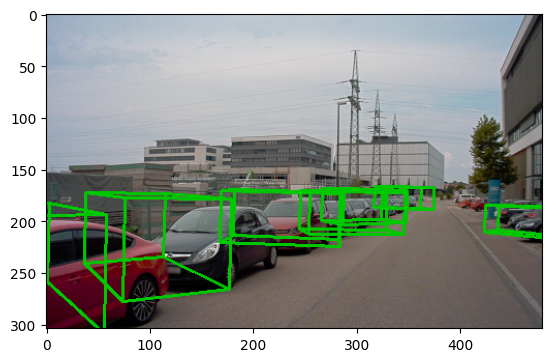

In [21]:
imobj= dataset[9]
image= imobj.image
image1= np.swapaxes(image, 0,2)
image2=  np.swapaxes(image1, 1,0)
image3= np.array(image2, dtype= 'uint8')
image3b= np.array(image2, dtype= 'uint8')
plt.imshow(image3)
f = open(r"E:\Thesis_Final\Baseline\M3D-RPN\result_new\9.txt", "r")
for line in f:
    print(line)
    x1= float(line.split(',')[3])
    y1= float(line.split(',')[4])
    x2= float(line.split(',')[5])
    y2= float(line.split(',')[6])
    box= [x1,y1,x2,y2]
    for j in range(len(box)):
        box[j]*=0.25
    #draw_2d_box(image3, box, color=(0, 200, 200), thickness=2)
    P = np.array([[ 1.00145047e+03, -1.66583918e+03,  3.52945654e+01, -1.74681545e+03],
                 [ 6.76424384e+02, -2.78547356e+01, -1.78625897e+03,  5.27308035e+02],
                    [ 9.99759581e-01,  2.13721864e-02, -4.90013971e-03, -1.70601282e+00],
                     [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

    #print(line)
    w3d= float(line.split(',')[7]) 
    h3d= float(line.split(',')[8]) 
    l3d= float(line.split(',')[9]) 
    x3d= float(line.split(',')[10])  
    y3d= float(line.split(',')[11]) 
    z3d= float(line.split(',')[12])
    ry3d= float(line.split(',')[13])
    
    verts= project_3d(P, x3d, y3d, z3d, w3d, h3d, l3d, ry3d, return_3d=False)
    draw_3d_box(image3, verts, color=(0, 200, 0), thickness=2)
plt.imshow(image3)
#path= "E:\Thesis_Final\Baseline\M3D-RPN\result_new_visualisation\image_{}".format(k)
#cv2.imwrite()

In [ ]:
for k in range(len(dataset)):
    print('k',k)
    imobj= dataset[k]
    image= imobj.image
    image1= np.swapaxes(image, 0,2)
    image2=  np.swapaxes(image1, 1,0)
    image3= np.array(image2, dtype= 'uint8')
    image3b= np.array(image2, dtype= 'uint8')
    #plt.imshow(image3)
    result_path=r"E:\Thesis_Final\Baseline\M3D-RPN\results_old\{}.txt".format(k)
    print(result_path)
    f = open(result_path, "r")
    for line in f:
        print(line)
        x1= float(line.split(',')[3])
        y1= float(line.split(',')[4])
        x2= float(line.split(',')[5])
        y2= float(line.split(',')[6])
        box= [x1,y1,x2,y2]
        for j in range(len(box)):
            box[j]*=0.25
        #draw_2d_box(image3, box, color=(0, 200, 200), thickness=2)
        P = np.array([[ 1.00145047e+03, -1.66583918e+03,  3.52945654e+01, -1.74681545e+03],
                 [ 6.76424384e+02, -2.78547356e+01, -1.78625897e+03,  5.27308035e+02],
                    [ 9.99759581e-01,  2.13721864e-02, -4.90013971e-03, -1.70601282e+00],
                     [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

        #print(line)
        w3d= float(line.split(',')[7]) 
        h3d= float(line.split(',')[8]) 
        l3d= float(line.split(',')[9]) 
        x3d= float(line.split(',')[10])  
        y3d= float(line.split(',')[11]) 
        z3d= float(line.split(',')[12])
        ry3d= float(line.split(',')[13])
    
        verts= project_3d(P, x3d, y3d, z3d, w3d, h3d, l3d, ry3d, return_3d=False)
        draw_3d_box(image3, verts, color=(0, 200, 0), thickness=2)
    #plt.imshow(image3)
    path= r"E:\Thesis_Final\Baseline\M3D-RPN\result_old_visualisation\image_{}.png".format(k)
    cv2.imwrite(path, image3)
